In [1]:
%%html
<style type="text/css">
input.good:checked + label {color: green}
input.bad:checked + label {color: red}
input.good:checked + label::after {color: green; content: ' Õige vastus!'}
input.bad:checked + label::after {color: red; content: ' Vale vastus!'}

.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Mittelineaarse ostsillaatori simulatsioon

See tööleht näitab, kuidas saab simuleerida mittelineaarse elektroonilise ostsillaatori võnkumist. Ostsillaatori võrrandite lahendamiseks kasutame SciPy ja NumPy, tulemuste joonistamiseks kasutame PyPlot. Lisaks vaatame Poincaré lõiget ja uurime, kas süsteem käitub perioodiliselt.

In [2]:
%matplotlib inline

from scipy.integrate import odeint
from scipy.io import wavfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import multiprocessing as mp

Jooniste suurus:

In [3]:
plt.rc('figure', figsize=(10.0, 7.5))

## Ostsillaatori definitsioon

See näide tegeleb mittelineaarse elektroonilise ostsillaatoriga. Ostsillaatori komponendid on vahelduvvoolu generaator, takistus, induktor ja (kondensaatori asemel) diood. Selle ostsillaatori võnkumist kirjeldab mitteautonoomne liikumisvõrrandite süsteem:

\begin{align}
\dot{U} &= \frac{I - I_d(U)}{C_d(U) + C_j(U)},\\
\dot{I} &= \frac{U_s\cos(\omega t) - U - RI}{L}.
\end{align}

Dünaamilised muutujad on dioodi pinge $U$ ja vool $I$. Siin $I_d(U)$ on difusioonivool, $C_d(U)$ on difusioonimahtuvus ja $C_j(U)$ on pn siirde mahtuvus. Nende soltuvust pingest kirjeldavad valemid

\begin{align}
I_d(U) &= I_f\left[1 - \exp\left(-\frac{U}{U_t}\right)\right],\\
C_d(U) &= C_f\exp\left(-\frac{U}{U_t}\right),\\
C_j(U) &= C_r\begin{cases}
\frac{1 - (1 + \gamma)f_s - \frac{\gamma U}{\phi}}{(1 - f_s)^{1 + \gamma}} & \text{kui } U < -f_s\phi\\
\left(1 + \frac{U}{\phi}\right)^{-\gamma} & \text{kui } U \geq -f_s\phi\\
\end{cases}.
\end{align}

Dünaamika sõltub järgnevatest konstantidest:

* takistus $R$
* induktsioon $L$
* küllastusvool $I_f$
* dioodi mahtuvused $C_f$, $C_r$
* difusiooni pinge $\phi$
* mahtuvuse koefitsient $\gamma$
* ülemineku parameeter $f_s$
* temperatuuripinge $U_t$
* generaatori sagedus $\omega$
* generaatori amplituud $U_s$

Kui me defineerime generaatori faasi $\theta = \omega t$, võime ostsillaatori ka kolmemõõtmelise autonoomse süsteemina kirjeldada. Sel juhul on liikumisvõrrandid:

\begin{align}
\dot{U} &= \frac{I - I_d(U)}{C_d(U) + C_j(U)},\\
\dot{I} &= \frac{U_s\cos\theta - U - RI}{L},\\
\dot{\theta} &= \omega.
\end{align}

Lisaks on algitingimuseks $\theta(0) = 0$. Mõned sobilikud konstantide väärtused on näiteks sellised:

In [5]:
defparam = {
    'res': 100.0,
    'ind': 2.367e-3,
    'Ut': 3.4e-2,
    'phi': 0.6,
    'gamma': 0.4,
    'If': 2.8e-12,
    'Cf': 5.6e-17,
    'Cr': 8.2e-11,
    'fs': 0.7
}
defparam['omega'] = 1 / np.sqrt(defparam['ind'] * defparam['Cr'])

Nende abil defineerime dioodi mahtuvust:

In [6]:
def dcap(U, Ut, phi, gamma, Cf, Cr, fs):
    C1 = Cf * np.exp(-U / Ut)
    if U < -fs * phi:
        C2 = Cr * (1 - fs * (1 + gamma) - gamma * U / phi) / (1 - fs) ** (1 + gamma)
    else:
        C2 = Cr * (1 + U / phi) ** (-gamma)
    return C1 + C2

Mahtuvust on ka mõistlik graafiliselt uurida:

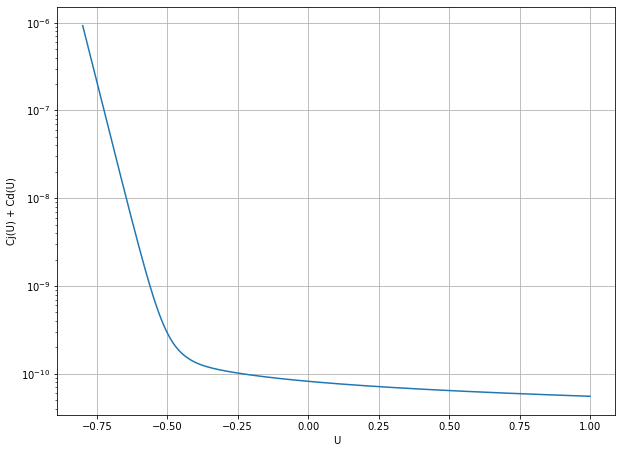

In [7]:
Uv = np.linspace(-0.8, 1.0, 251)
Cv = [dcap(U, defparam['Ut'], defparam['phi'], defparam['gamma'], defparam['Cf'], defparam['Cr'], defparam['fs']) for U in Uv]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel("U")
ax.set_ylabel("Cj(U) + Cd(U)")
ax.plot(Uv, Cv)
ax.grid()
plt.show()

Lisaks ka difusioonivool:

In [8]:
def dcur(U, Ut, If):
    return If * (1 - np.exp(-U / Ut))

Samuti joonistame ka voolu. Avasuunas kasvab vool eksponentsiaalselt:

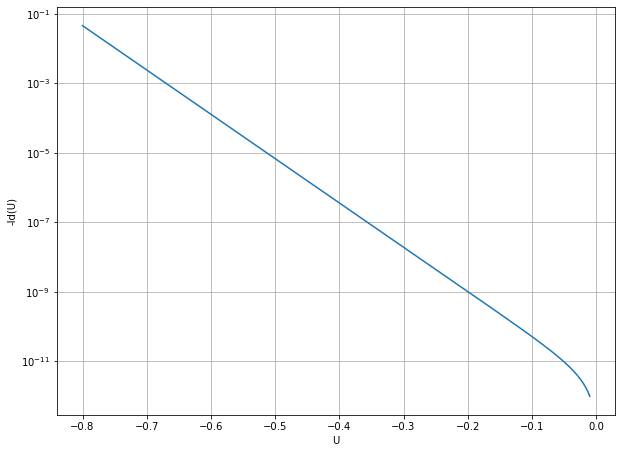

In [9]:
Uv = np.linspace(-0.8, -0.01, 251)
Iv = [-dcur(U, defparam['Ut'], defparam['If']) for U in Uv]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel("U")
ax.set_ylabel("-Id(U)")
ax.plot(Uv, Iv)
ax.grid()
plt.show()

Tõkkesuunas kasvab vool kuni küllastusvooluni:

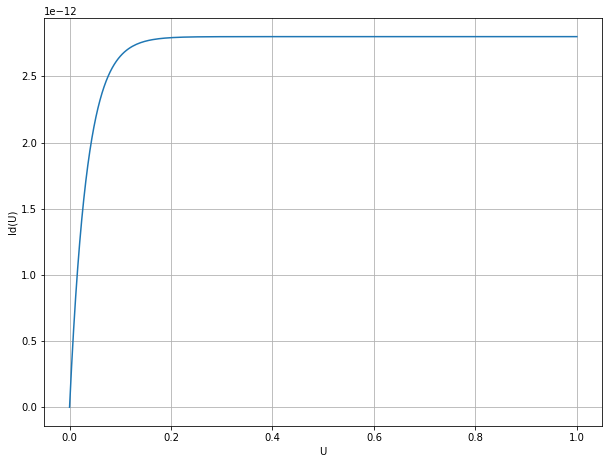

In [10]:
Uv = np.linspace(0.0, 1.0, 251)
Iv = [dcur(U, defparam['Ut'], defparam['If']) for U in Uv]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel("U")
ax.set_ylabel("Id(U)")
ax.plot(Uv, Iv)
ax.grid()
plt.show()

Generaatori amplituudiga võib katsetada - siin on mõned huvitavad väärtused:

In [11]:
Usvals = [0.7, 1.0, 2.0, 3.0, 3.3, 3.5, 4.0, 5.0, 5.6, 5.7, 7.0, 7.8, 12.5, 15.0]

Lõpuks defineerime süsteemi dünaamikat:

In [12]:
def osc(y, t, res, ind, Us, Ut, phi, gamma, If, Cf, Cr, fs, omega):
    U, I = y
    Cd = dcap(U, Ut, phi, gamma, Cf, Cr, fs)
    Id = dcur(U, Ut, If)
    dydt = [(I - Id) / Cd, (Us * np.cos(omega * t) - U - res * I) / ind]
    return dydt

## Liikumisvõrrandite lahendamine

Liikumisvõrrandite lahendamiseks on meil lisaks dünaamikale ka algtingimusi vaja. Siin eeldame et alguses, $t = 0$, kehtib $U(0) = 0$ ja $I(0) = 0$.

In [13]:
y0 = [0.0, 0.0]

Järgmisena valime, millises ajavahemikus me soovime võrrandeid lahendada. Vahemik on valitud nii, et kui võnkumisi konverteeritakse helifailiks, siis helifaili kestus on 12s. Lisaks defineerime audio diskreetimissagedus (*sampling rate*), tavaline valik on 44100 (heli CD). Integreerimissammu valime selliseks, et jagame generaatori perioodi 100 sammuks. Sellest järeldub, et heli sagedus on 441Hz.

In [14]:
afreq = 441
smpper = 100
perplot = 25
perpre = 100
duration = 12

Nende konstantidega defineerime ajavahemiku $T = [t_0, t_1]$, milles liikumisvõrrandeid lahendada.

In [15]:
periods = duration * afreq
smprt = afreq * smpper
time = 2 * np.pi * periods / defparam['omega']
nsmp = smpper * perplot
presmp = smpper * perpre
samples = duration * smprt + 1
t = np.linspace(0, time, samples)
phase = np.linspace(0, 2 * np.pi, smpper + 1)

print("Simulatsiooni omadused:")
print("Generaatori perioodide arv: %d" % periods)
print("Reaalaja kestus: %fs" % time)
print("Sammud perioodi kohta: %d" % smpper)
print("Sammud kokku: %d" % (samples - 1))
print()
print("Eelvõnkumine:")
print("Perioodide arv: %d" % perpre)
print("Reaalaeg: %fs" % (2 * np.pi * perpre / defparam['omega']))
print()
print("Jooniste omadused:")
print("Joonistatud perioodide arv: %d" % perplot)
print("Joonistatud reaalaeg: %fs" % (2 * np.pi * perplot / defparam['omega']))
print()
print("Helifaili omadused:")
print("Kuulamisaja kestus: %fs" % duration)
print("Diskreetimissagedus: %dHz" % smprt)
print("Baastooni helisagedus: %dHz" % afreq)

Simulatsiooni omadused:
Generaatori perioodide arv: 5292
Reaalaja kestus: 0.014649s
Sammud perioodi kohta: 100
Sammud kokku: 529200

Eelvõnkumine:
Perioodide arv: 100
Reaalaeg: 0.000277s

Jooniste omadused:
Joonistatud perioodide arv: 25
Joonistatud reaalaeg: 0.000069s

Helifaili omadused:
Kuulamisaja kestus: 12.000000s
Diskreetimissagedus: 44100Hz
Baastooni helisagedus: 441Hz


Lõpuks kasutame SymPy funktsiooni ```odeint``` võrrandite lahendamiseks. Seda võib objektiklassina kirjutada, selleks et me saame hiljem mitu koopiat paralleelarvutuses käivitada.

In [16]:
class oscint(object):
    def __init__(self, y0, time, param, var):
        self.y0 = y0
        self.time = time
        self.param = param
        self.var = var
        
    def __call__(self, d):
        param = self.param
        param[self.var] = d
        return odeint(osc, self.y0, self.time, args = (param['res'], param['ind'], param['Us'], param['Ut'], param['phi'], param['gamma'], param['If'], param['Cf'], param['Cr'], param['fs'], param['omega']))

Siis käivitame arvutust iga amplituudi väärtuse kohta.

In [17]:
ampint = oscint(y0, t, defparam, 'Us')

with mp.Pool() as pool:
    sols = dict(zip(Usvals, pool.map(ampint, Usvals)))

## Lahendite joonistamine

Saadud lahendeid võime erineval viisil joonistada.

### Pinge sõltuvalt ajast

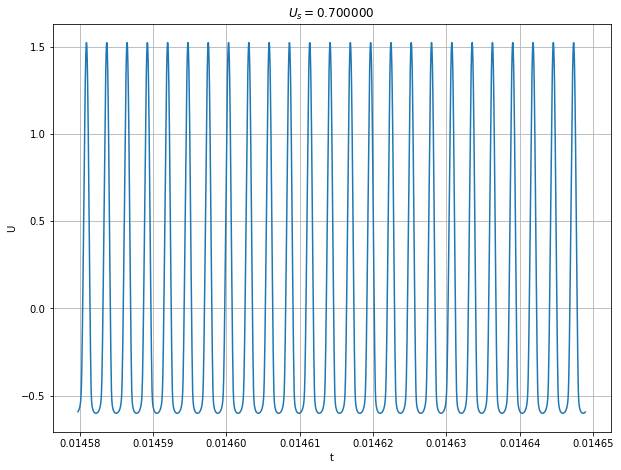

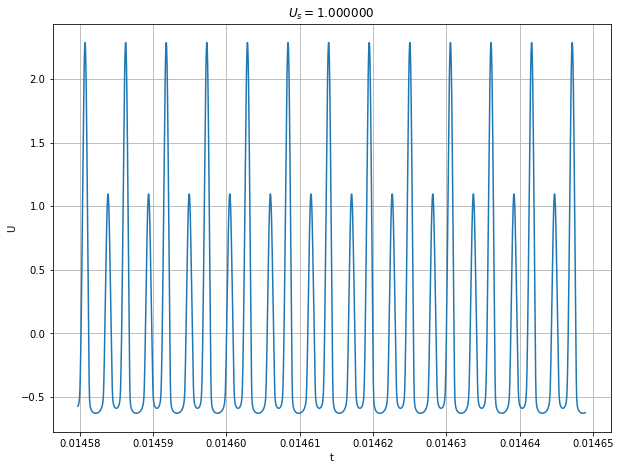

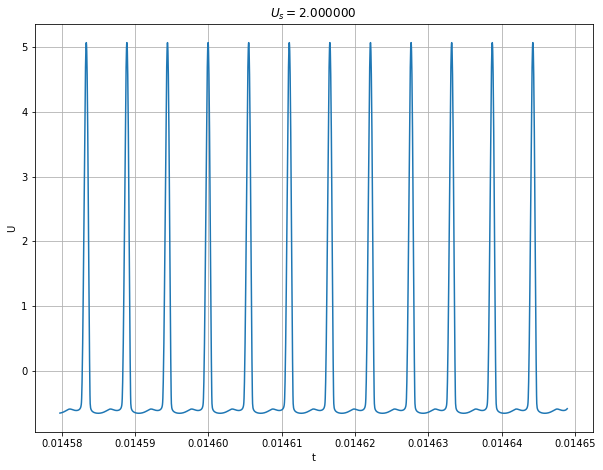

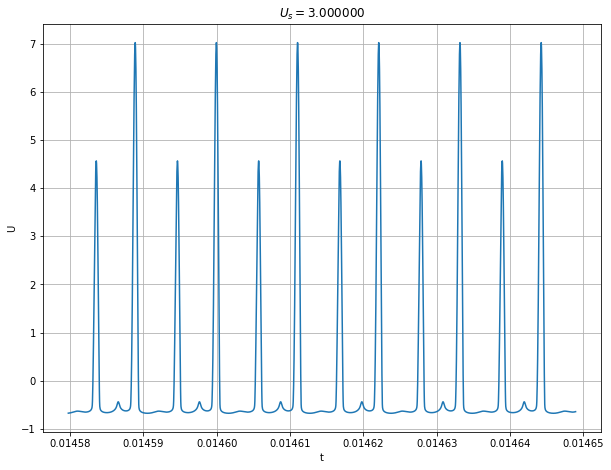

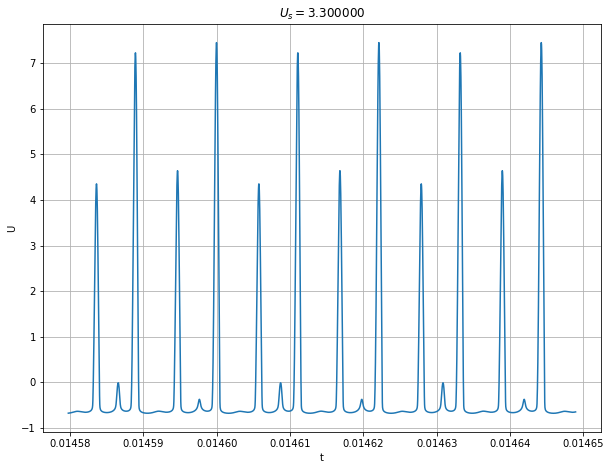

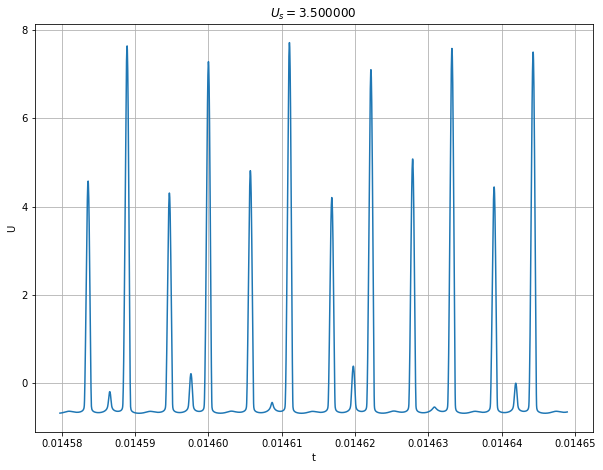

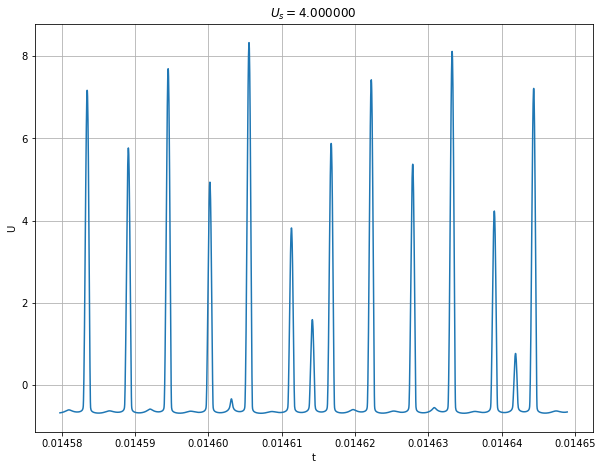

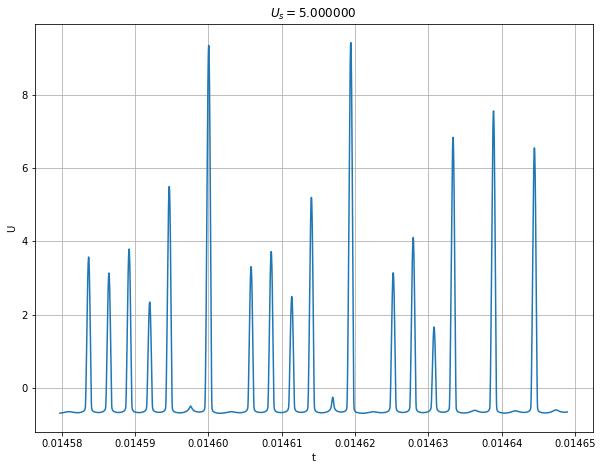

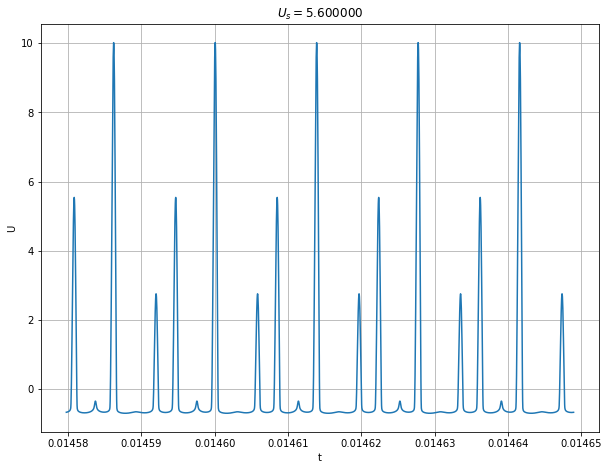

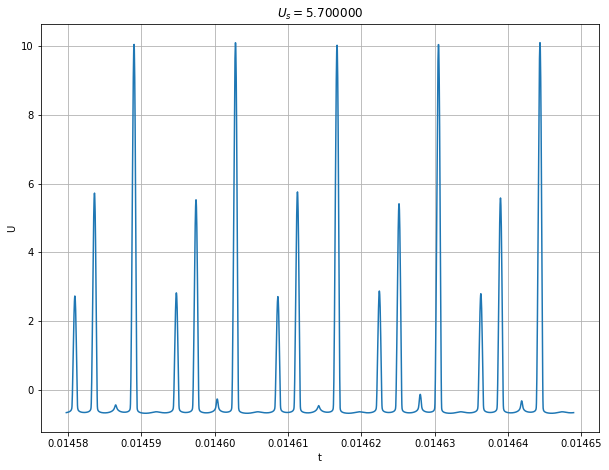

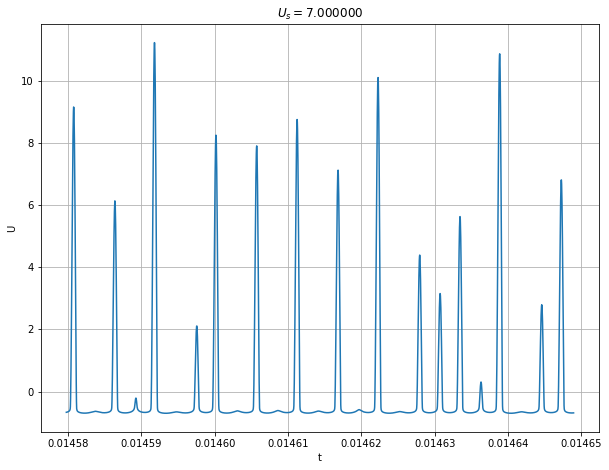

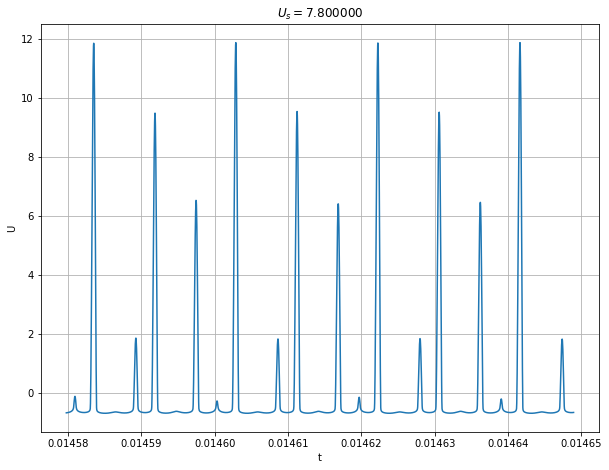

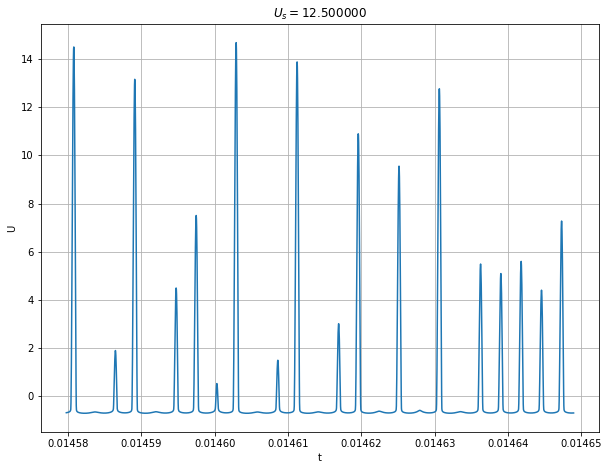

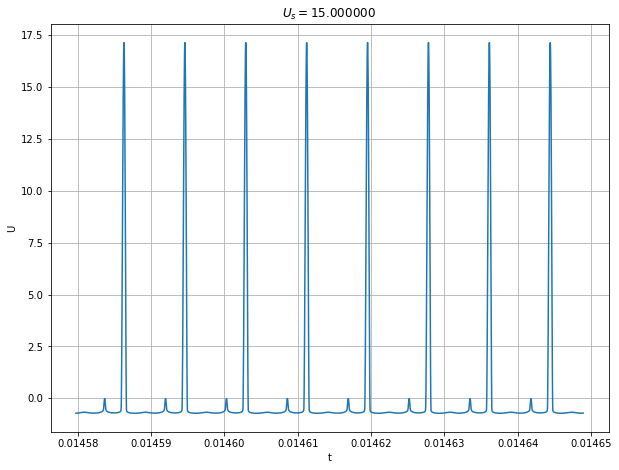

In [18]:
for Us, sol in sols.items():
    plt.plot(t[-nsmp:], sol[-nsmp:, 0])
    plt.title("$U_s = %f$" % Us)
    plt.xlabel("t")
    plt.ylabel("U")
    plt.grid()
    plt.show()

### Vool sõltuvalt ajast

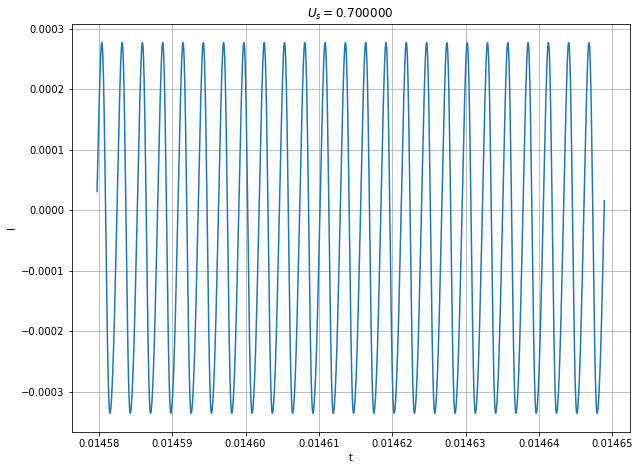

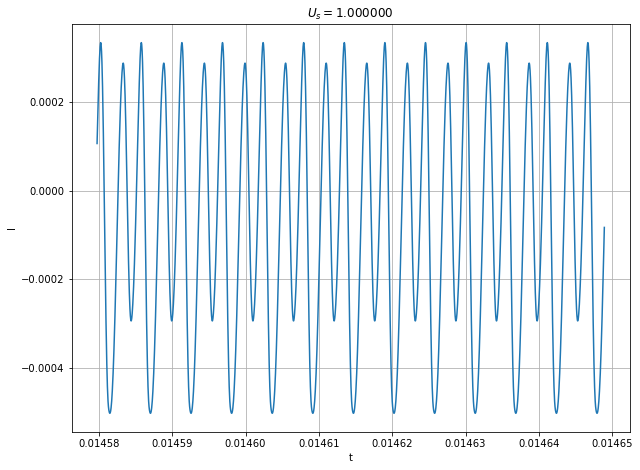

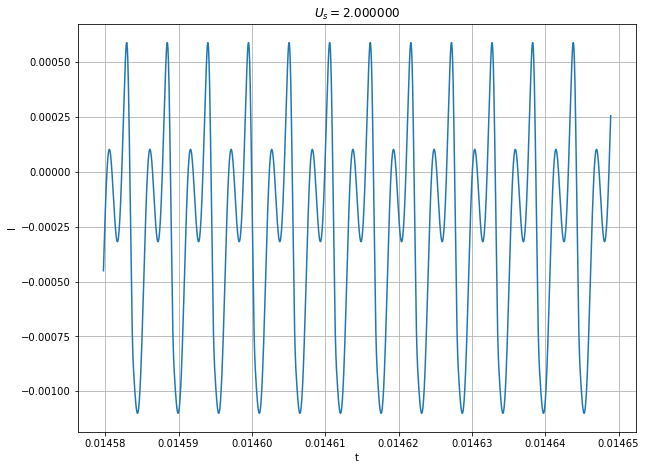

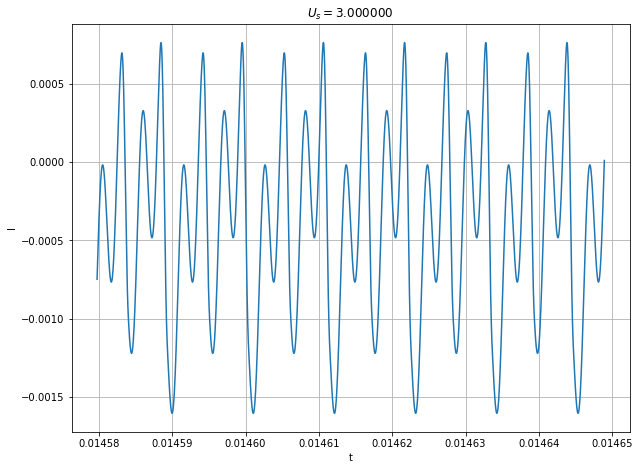

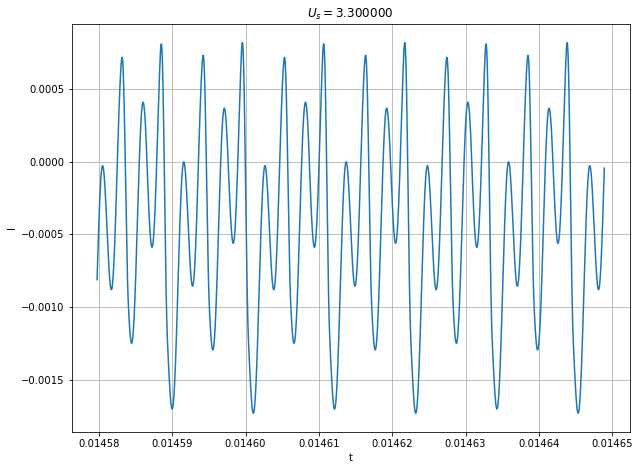

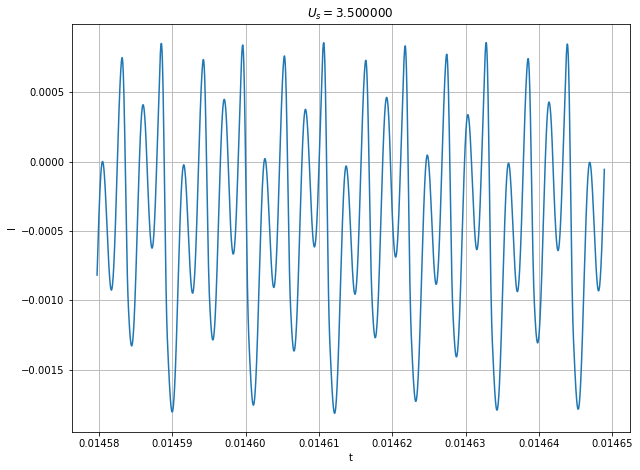

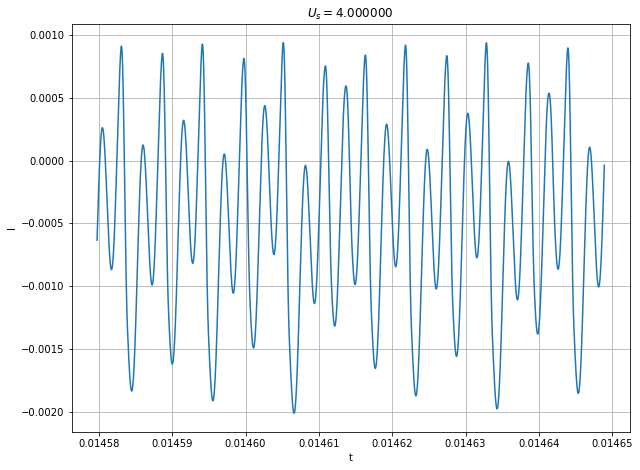

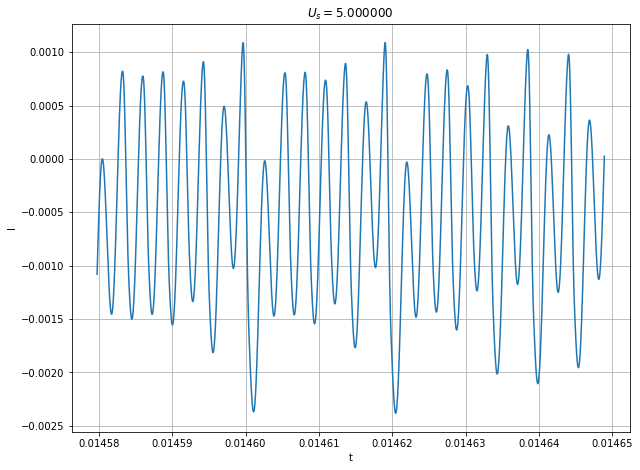

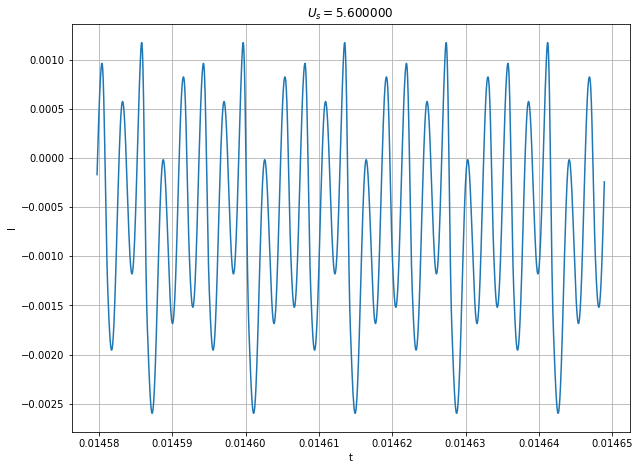

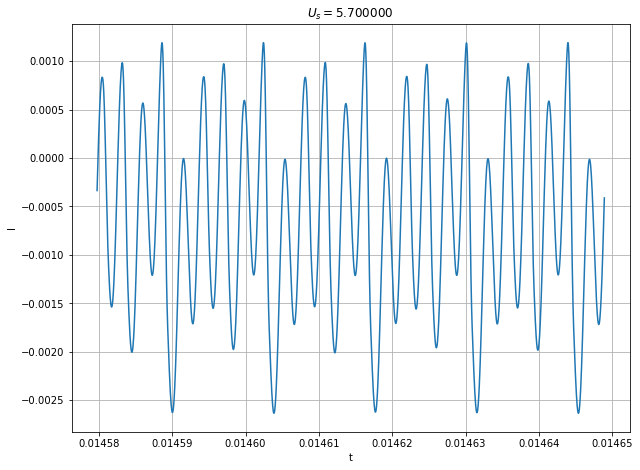

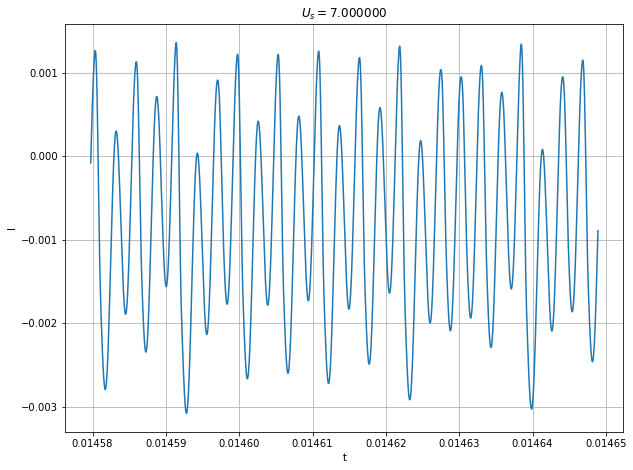

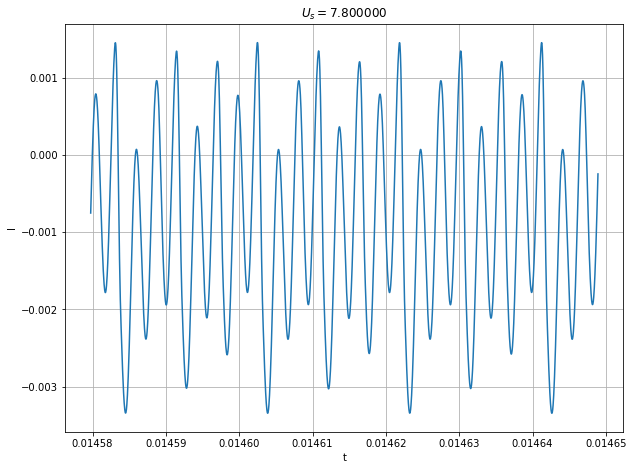

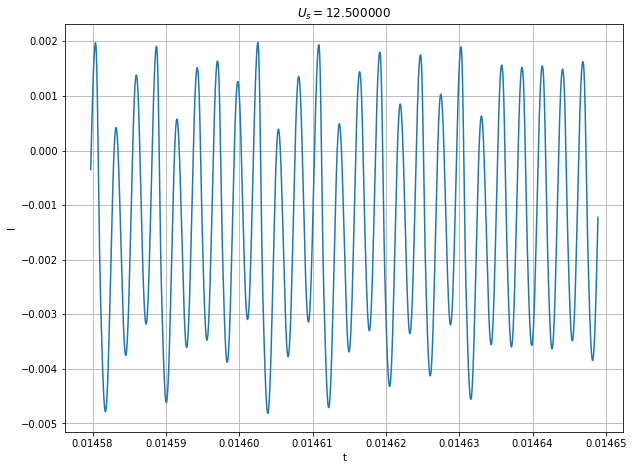

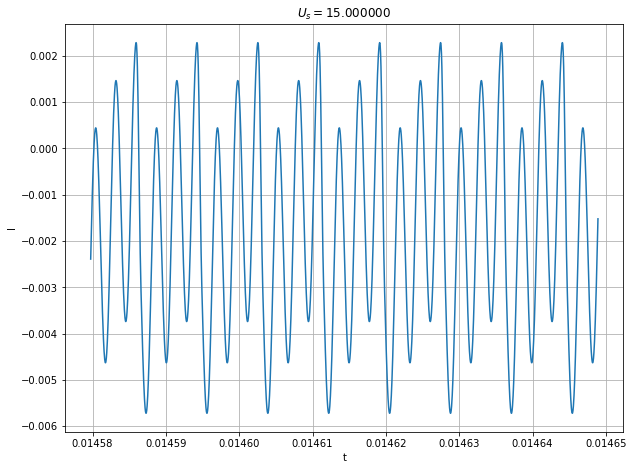

In [19]:
for Us, sol in sols.items():
    plt.plot(t[-nsmp:], sol[-nsmp:, 1])
    plt.title("$U_s = %f$" % Us)
    plt.xlabel("t")
    plt.ylabel("I")
    plt.grid()
    plt.show()

### Pinge vs vool

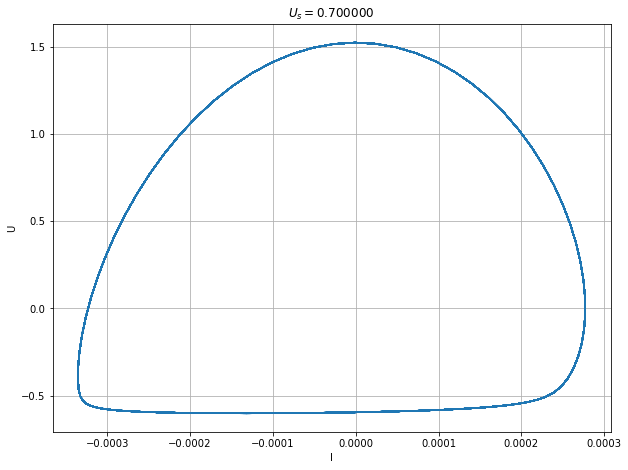

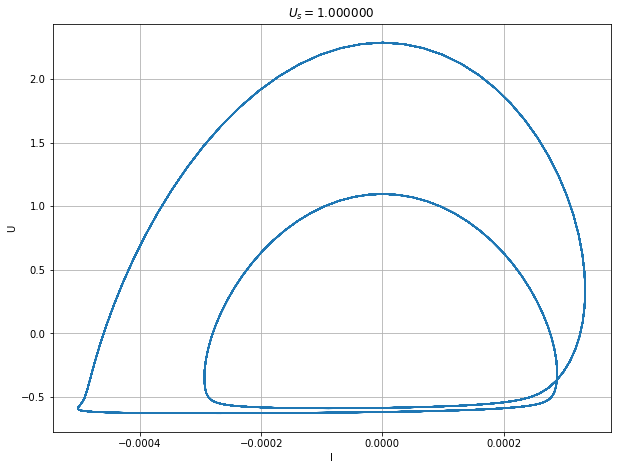

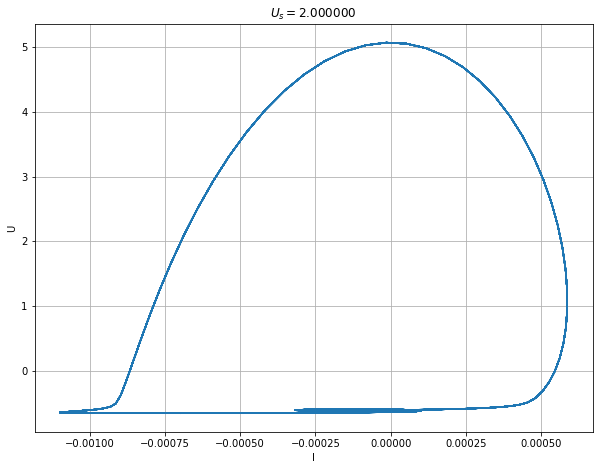

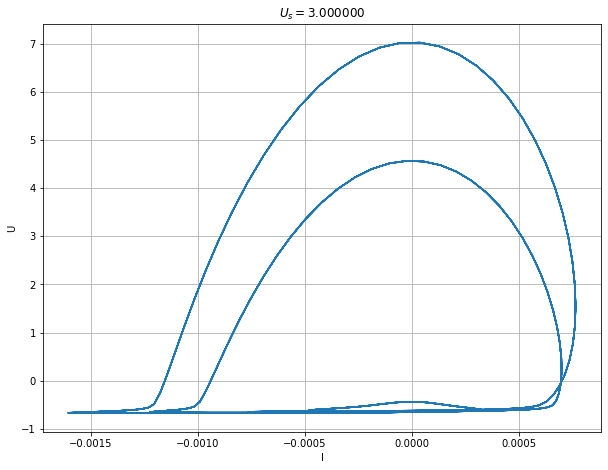

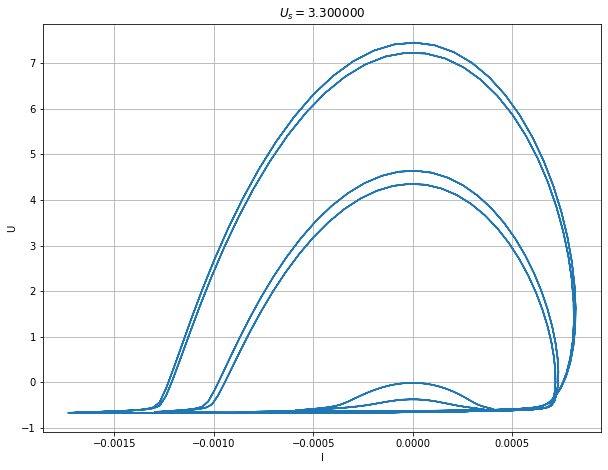

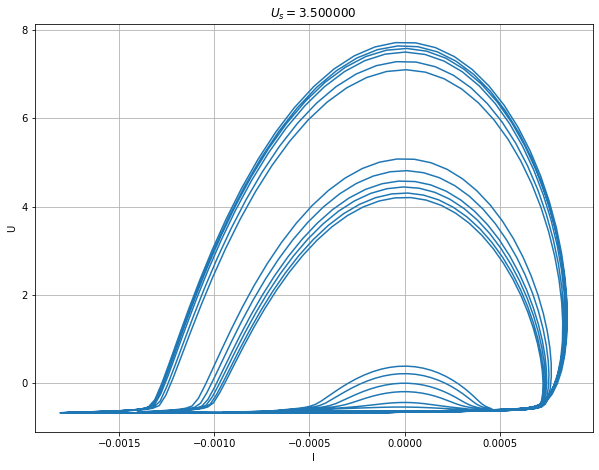

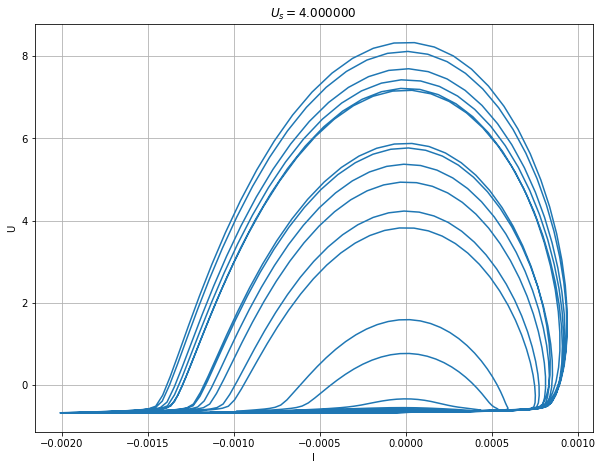

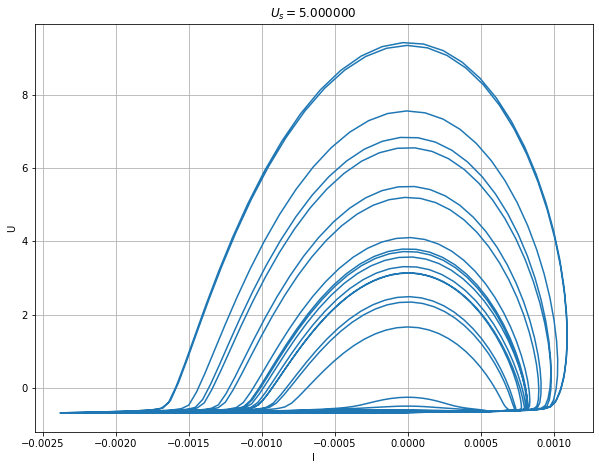

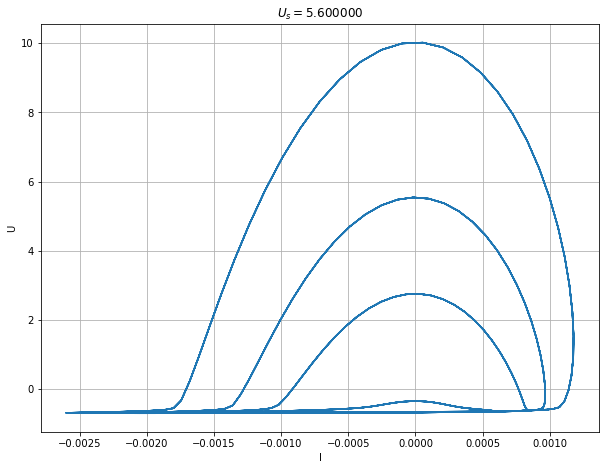

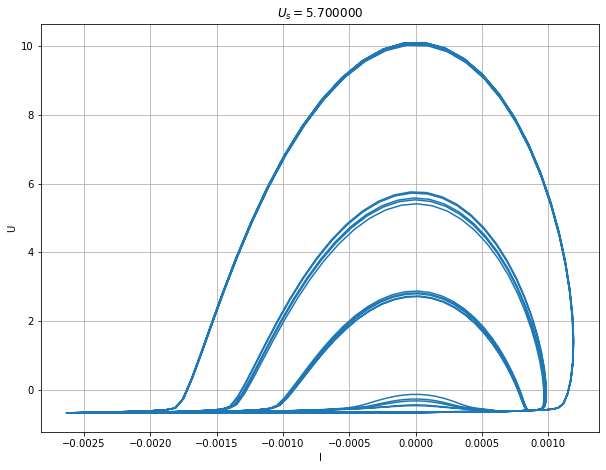

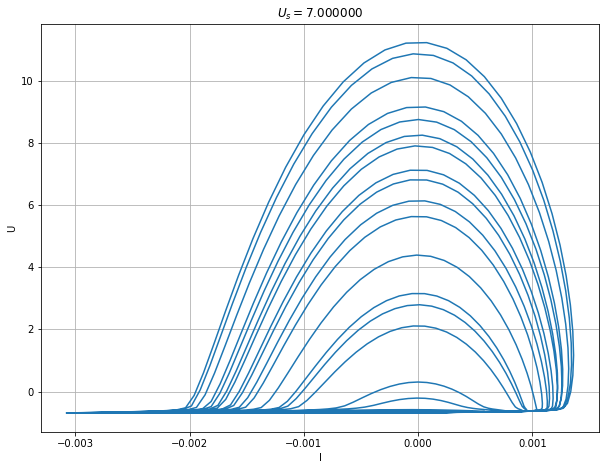

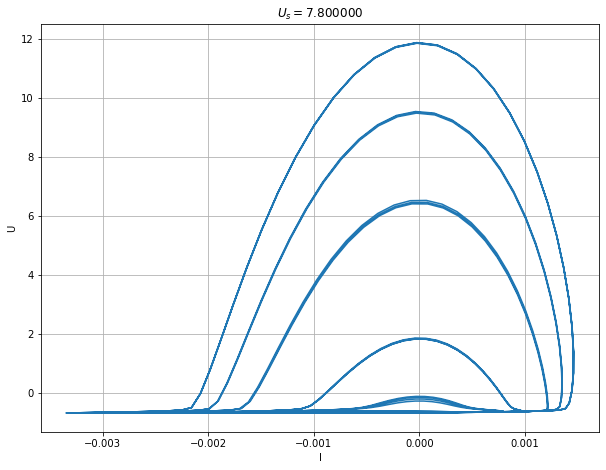

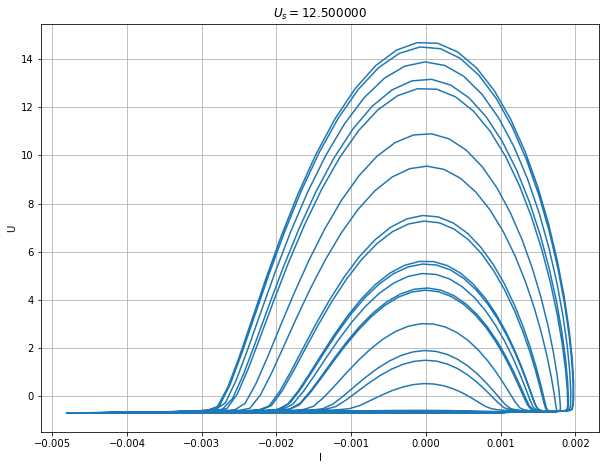

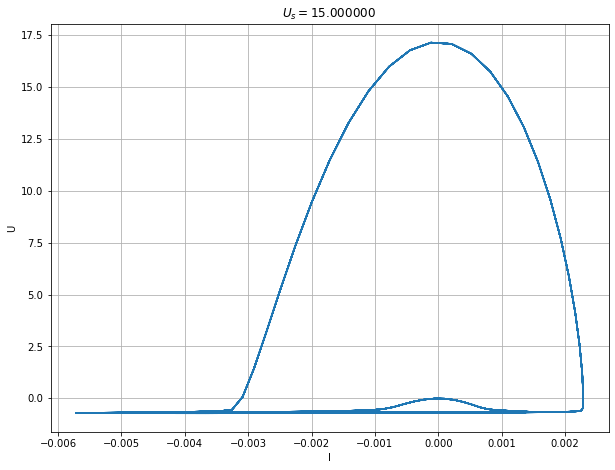

In [20]:
for Us, sol in sols.items():
    plt.plot(sol[-nsmp:, 1], sol[-nsmp:, 0])
    plt.title("$U_s = %f$" % Us)
    plt.xlabel("I")
    plt.ylabel("U")
    plt.grid()
    plt.show()

### Trajektoor faasiruumis

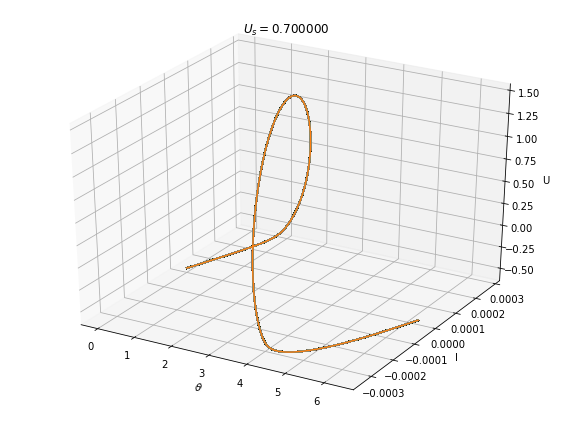

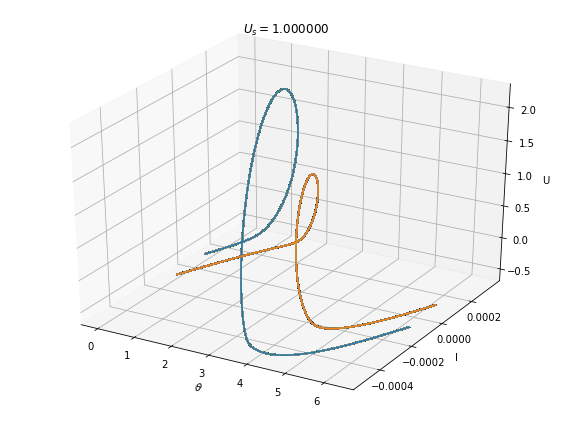

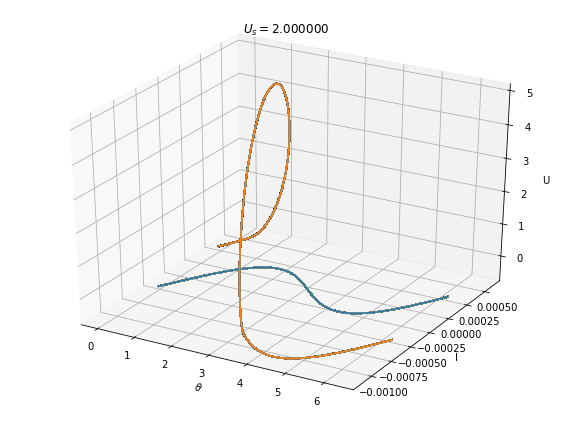

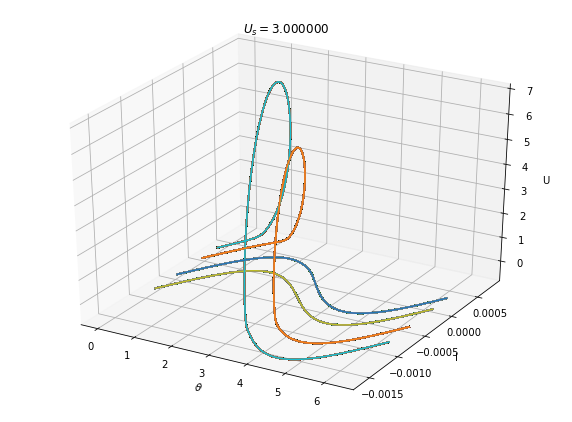

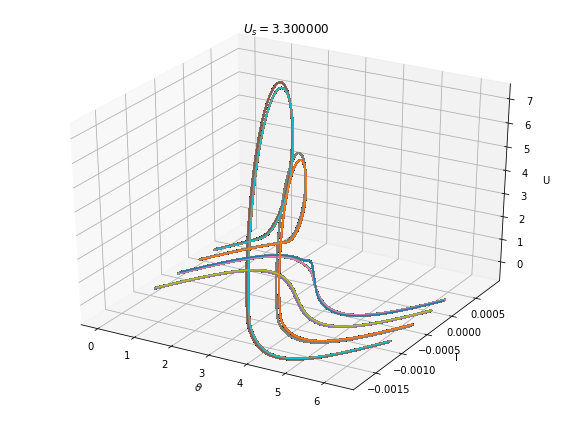

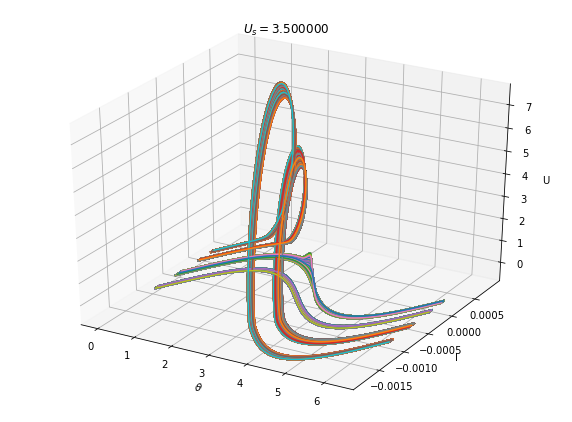

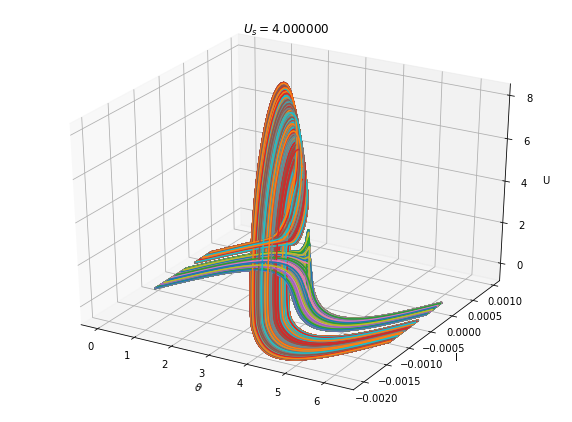

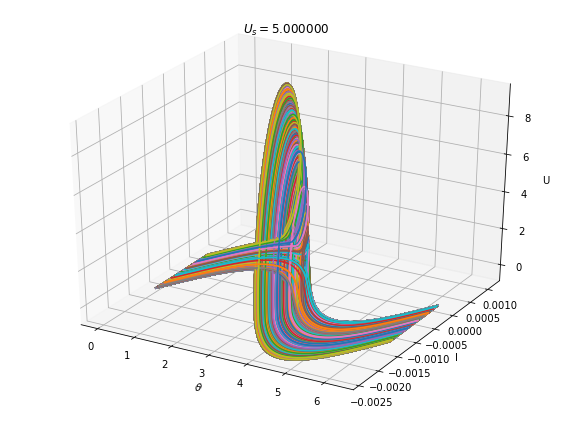

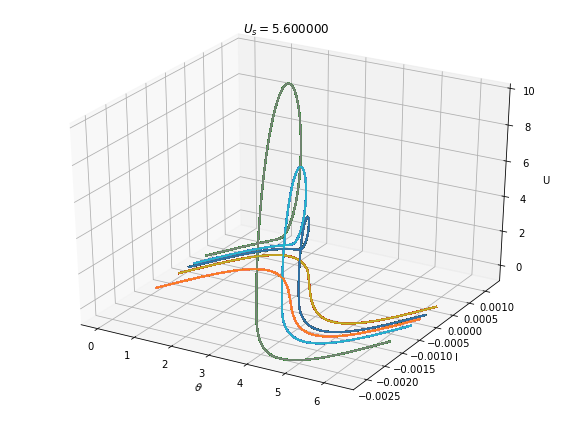

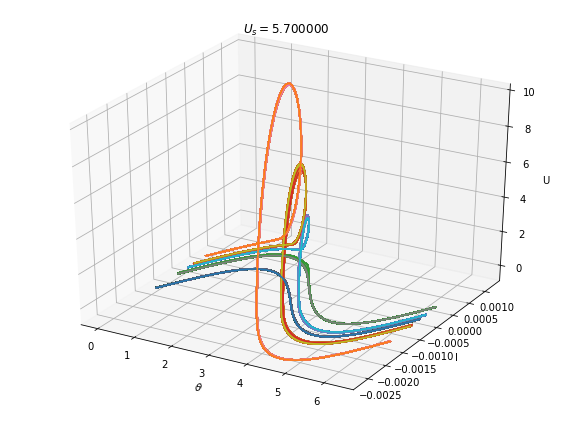

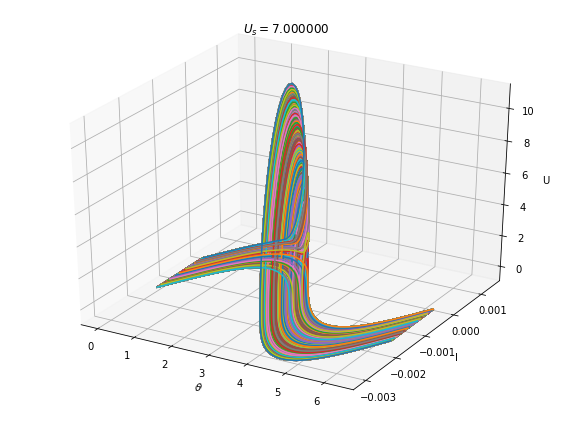

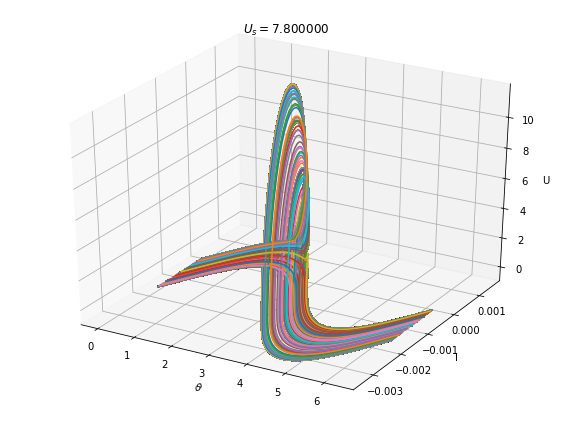

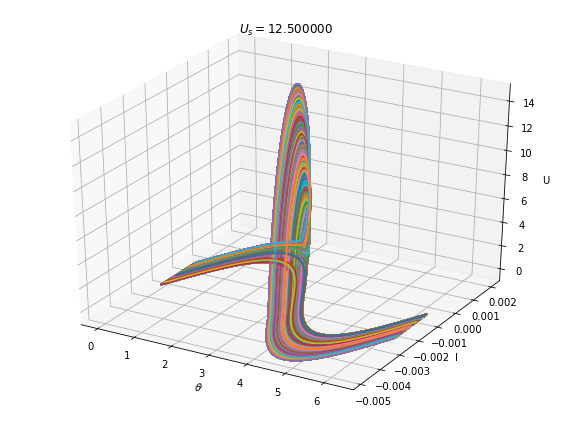

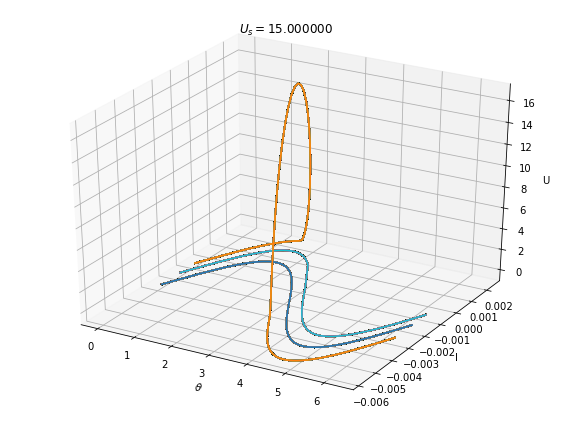

In [21]:
for Us, sol in sols.items():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    for n in range(periods - perpre):
        ax.plot(phase, sol[-(n + 1) * smpper - 2:-n * smpper - 1, 1], sol[-(n + 1) * smpper - 2:-n * smpper - 1, 0])
    ax.set_title("$U_s = %f$" % Us)
    ax.set_xlabel("$\\theta$")
    ax.set_ylabel("I")
    ax.set_zlabel("U")
    plt.show()

## Poincaré lõige

Järgmisena joonistame Poincaré lõiget. Selleks jätame siirdeseisundi (näiteks 10000 sammu) simulatsiooni alguses ära, ja joonistame ainult seda osa, kui võnkumine on juba lähenenud stabiilsele olekule. Siis joonistame ainult ühe punkti igast generaatori perioodist, ehk igat 100. sammu. Poincaré lõige sõltub generaatori faasist.

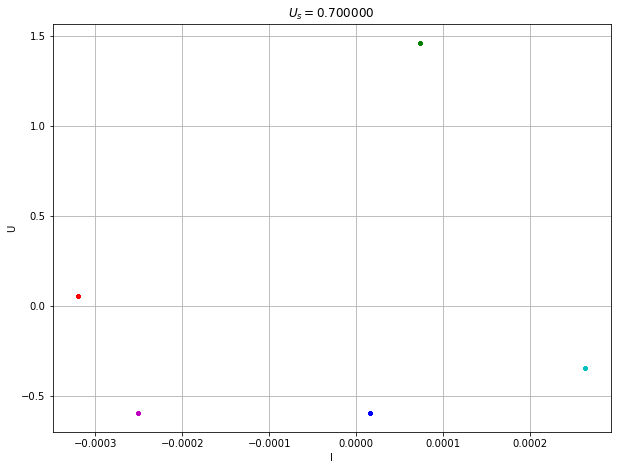

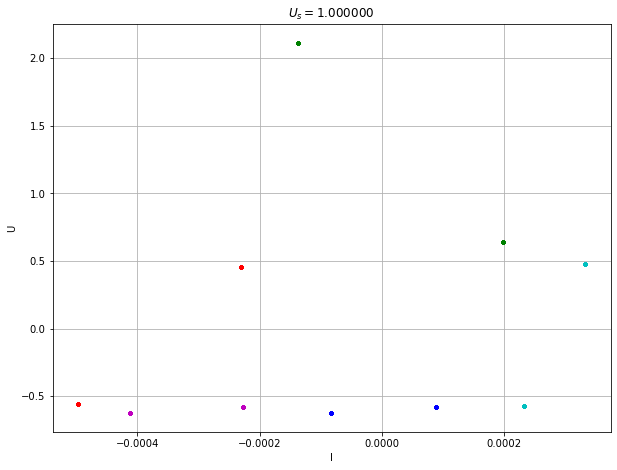

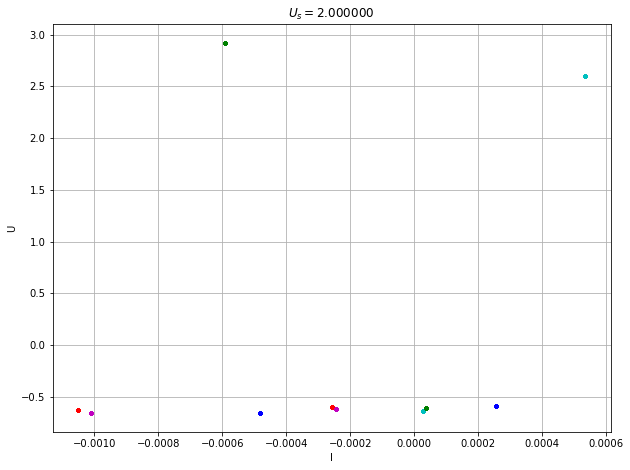

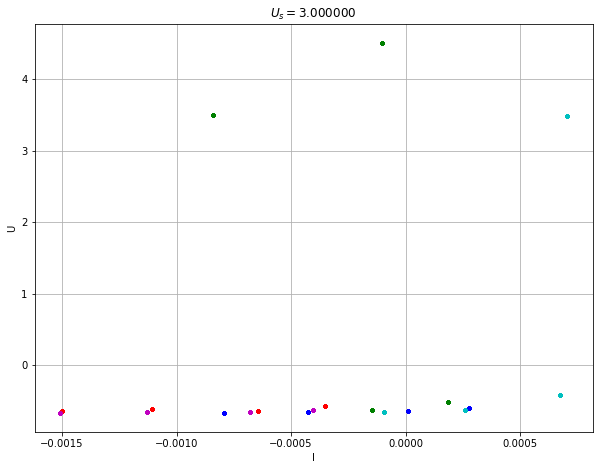

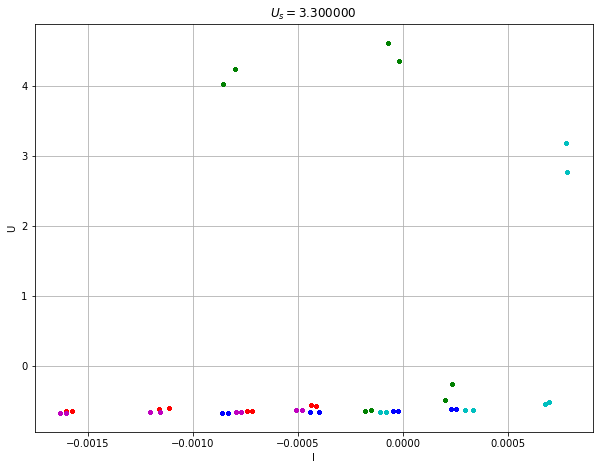

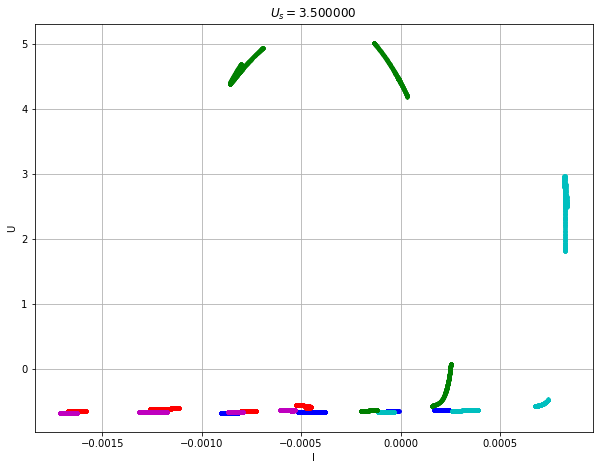

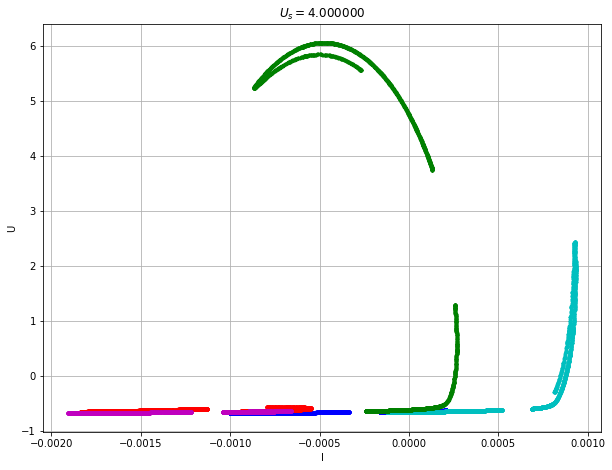

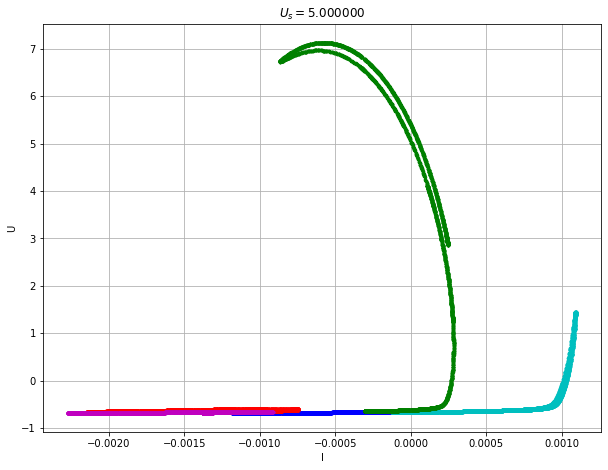

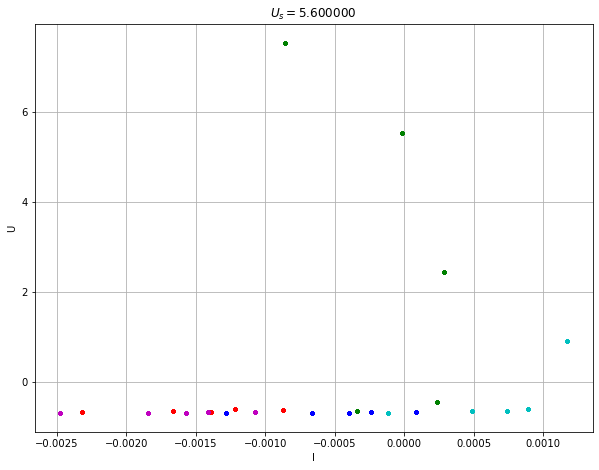

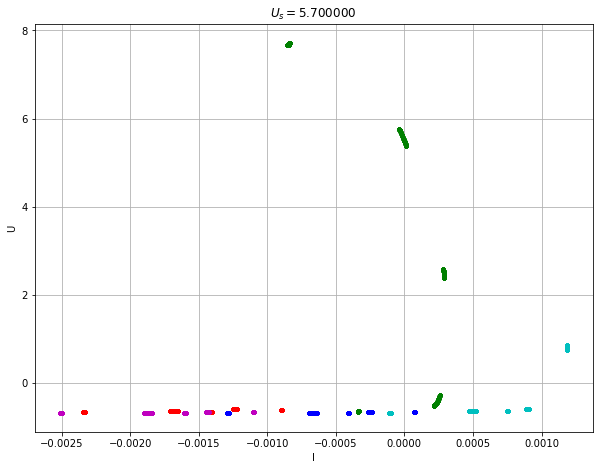

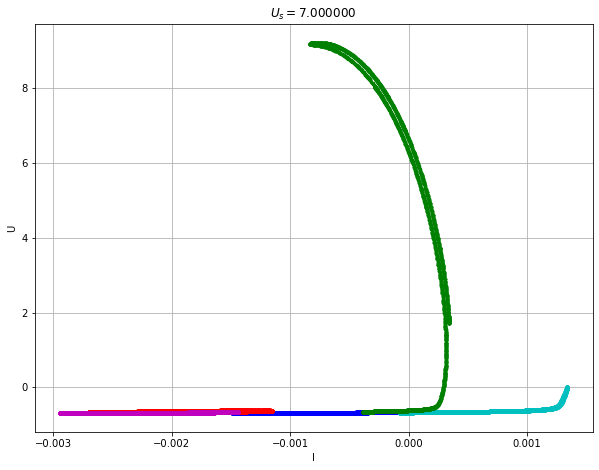

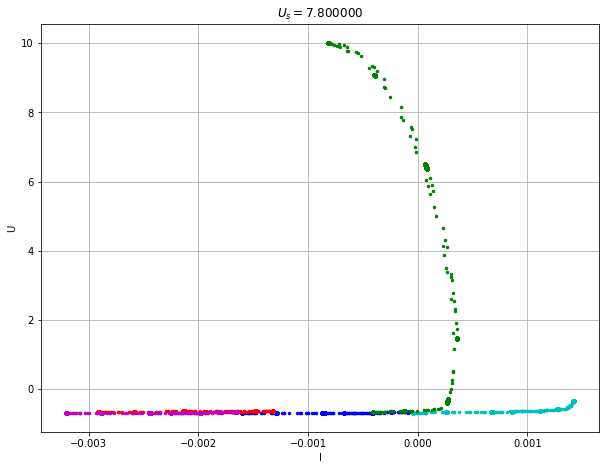

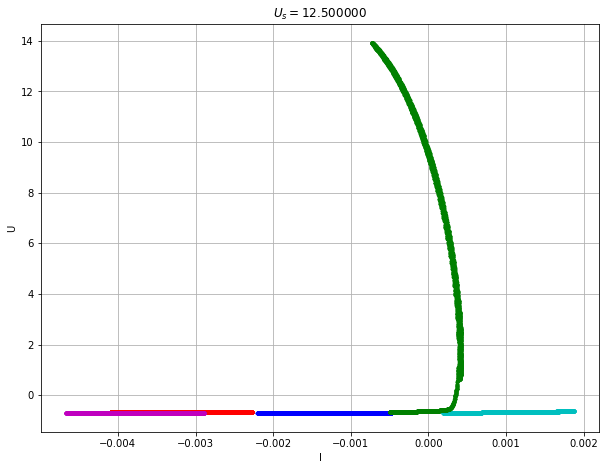

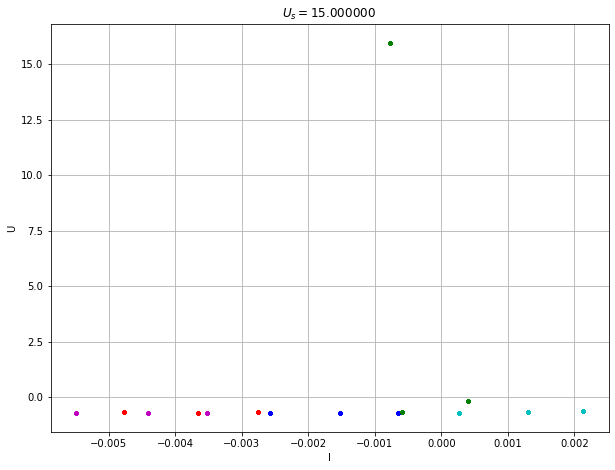

In [22]:
cols = ['b.', 'c.', 'g.', 'r.', 'm.']
for Us, sol in sols.items():
    for ph in range(len(cols)):
        first = perpre * smpper + ph * smpper // len(cols)
        plt.plot(sol[first::smpper, 1], sol[first::smpper, 0], cols[ph], markersize=5)
    plt.title("$U_s = %f$" % Us)
    plt.xlabel("I")
    plt.ylabel("U")
    plt.grid()
    plt.show()

Kui trajektoor on perioodiline, on punktide arv lõplik ja joonis näitab diskreetseid punkte. Kui trajektoor on mitteperioodiline, tekib igas generaatoriperioodis uus punkt, ja joonis on mittediskreetne.

## Sageduse spekter

Fourier teisenduse abil saame sageduse spektri arvutada. Antud juhul on meie jaoks huvitav vaid absoluutne amplituud konkreetse sageduse juures, seega arvutame võimsusspektri. Sageduse ühikuks tasub valida generaatori sagedust. Spekter näitab perioodide kahekordistumisi, kui tekib tipp vastava sageduse juures.

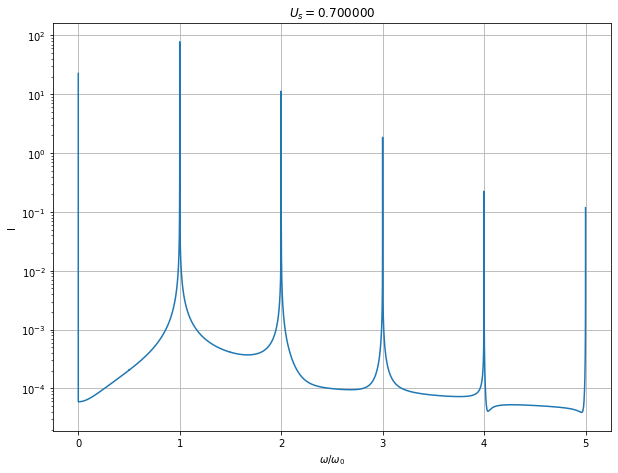

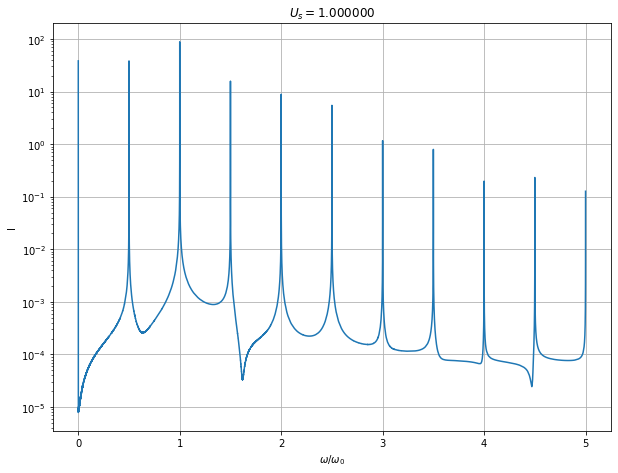

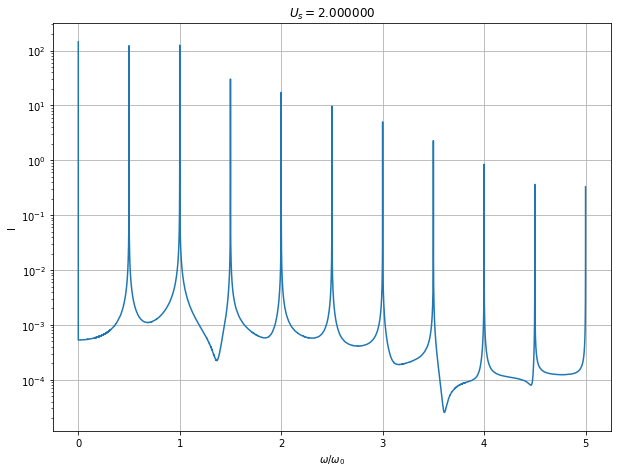

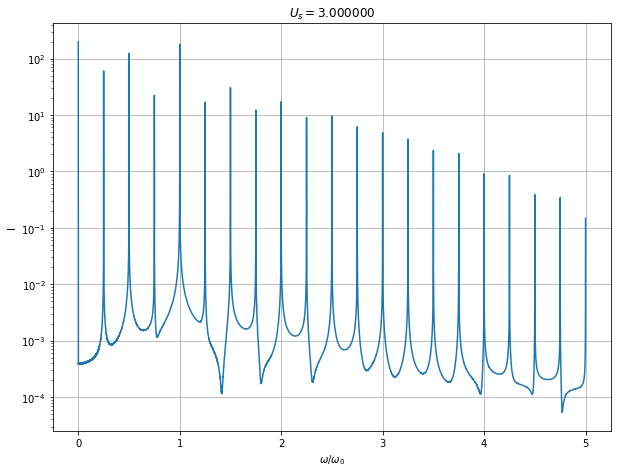

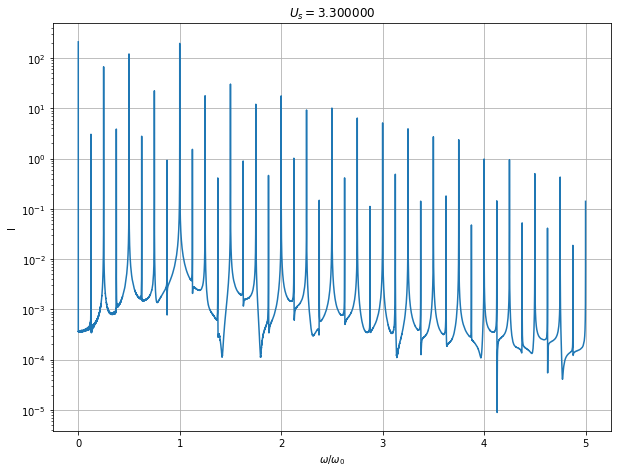

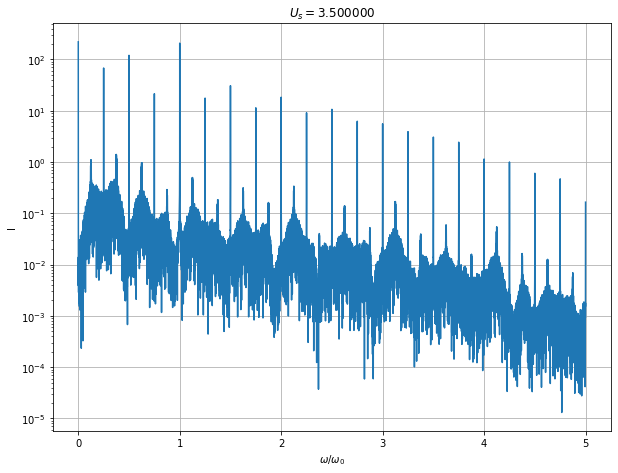

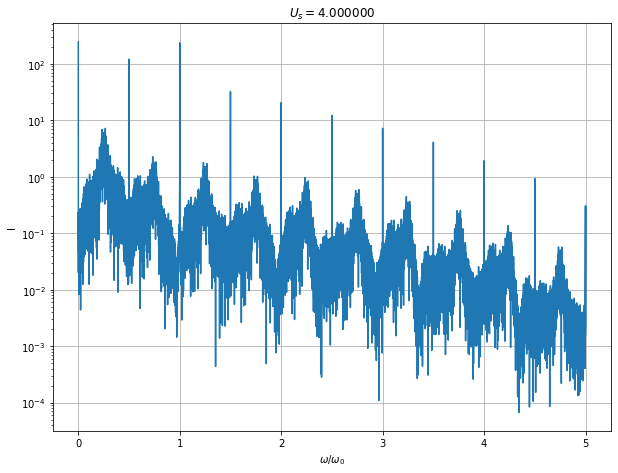

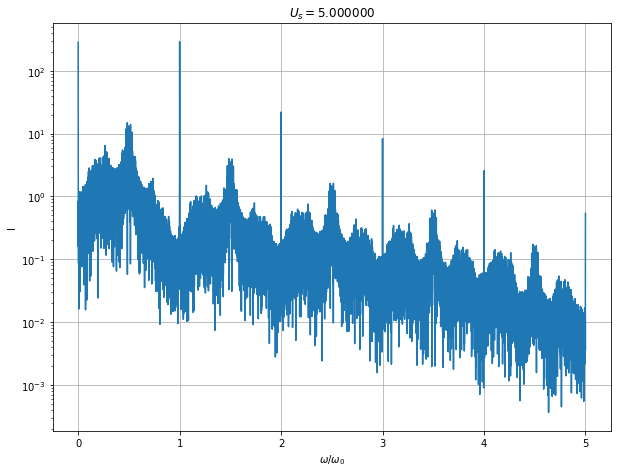

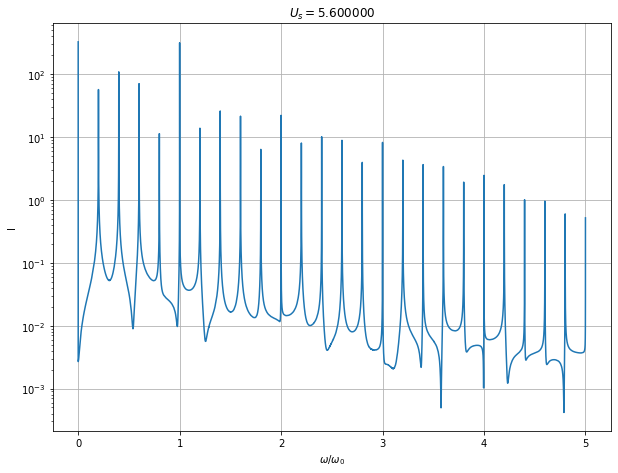

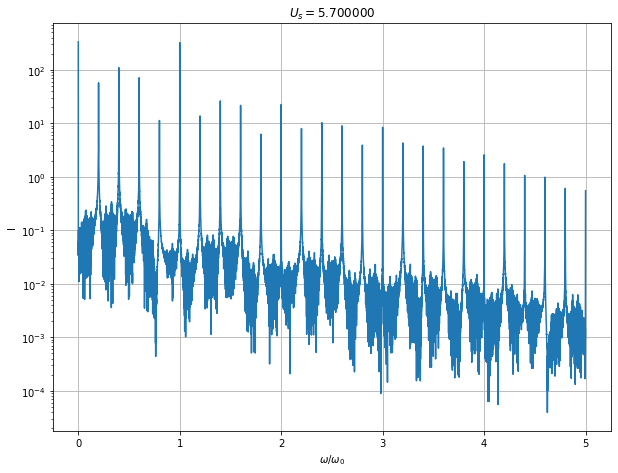

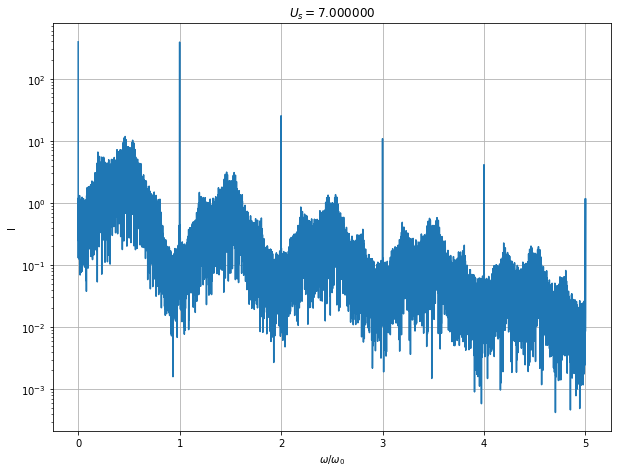

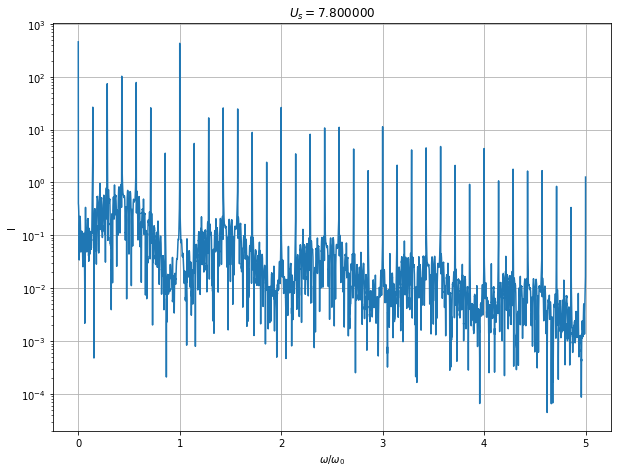

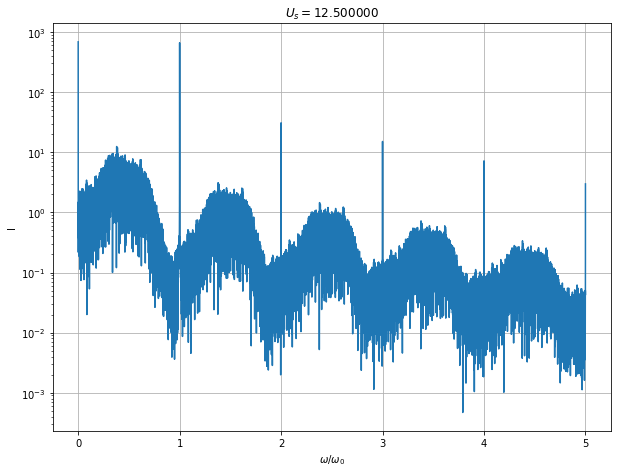

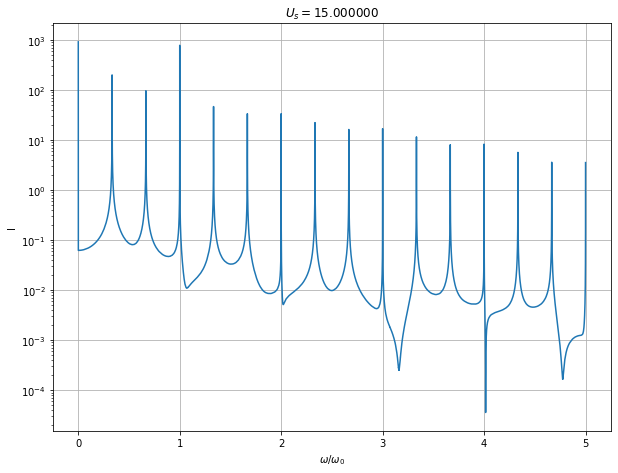

In [23]:
nfreqs = 5

fmax = nfreqs * (periods - perpre) + 1
freqs = np.linspace(0, nfreqs, fmax)

for Us, sol in sols.items():
    spec = np.absolute(np.fft.rfft(sol[presmp:, 1]))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_title("$U_s = %f$" % Us)
    ax.set_xlabel('$\\omega / \\omega_0$')
    ax.set_ylabel('I')
    ax.plot(freqs, spec[:fmax])
    ax.grid()
    plt.show()

## Feigenbaumi diagramm

Lõpuks joonistame Feigenbaumi diagrammi. Selleks simuleerime 1600 generaatori perioodi, ja joonistame neist vaid 200 viimast. Iga perioodi kohta simuleerime 100 ajasammu.

In [25]:
steps = 100
periods = 1600
samples = 200

nt = steps * periods
tmax = 2.0 * np.pi * periods / defparam['omega']
t = np.linspace(0, tmax, nt + 1)

Selle süsteemi huvitav parameetri vahemik on $U_s \in [0, 15]$. Vahemikku jagame 1500 sammuks.

In [26]:
Usmax = 15.0
Usmin = 0.0
nUs = 1500

Uss = np.linspace(Usmin, Usmax, nUs + 1)
Usplot = np.transpose(np.broadcast_to(Uss, (samples, nUs + 1))).flat

Süsteemi simuleerimiseks kasutame funktsiooni ```odeint```. See võtab aega!

In [27]:
ampint = oscint(y0, t, defparam, 'Us')

with mp.Pool() as pool:
   sol = np.array(pool.map(ampint, Uss))

Tulemuse joonistamiseks kasutame funktsiooni ```scatter```. Siin on joonistatud nii pinge kui vool, ja on valitud erinevad generaatori faasid.

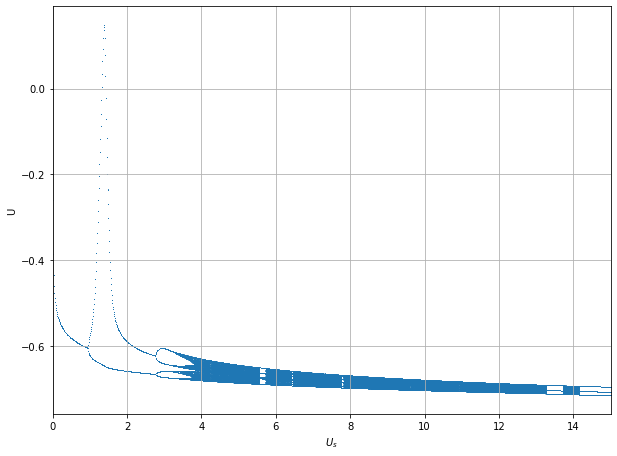

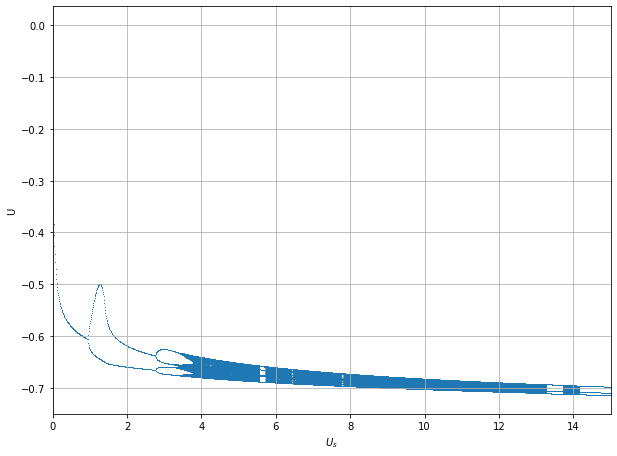

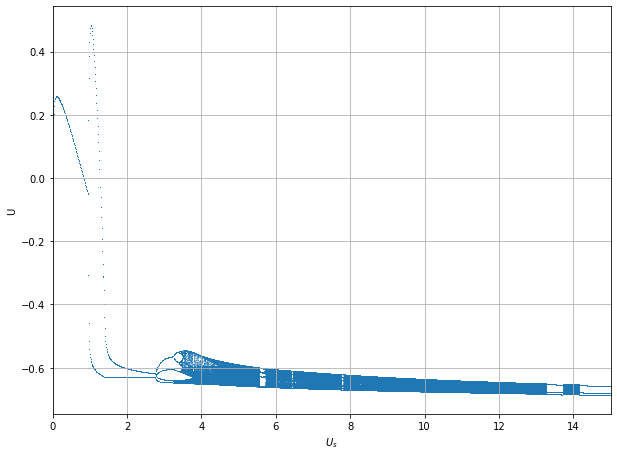

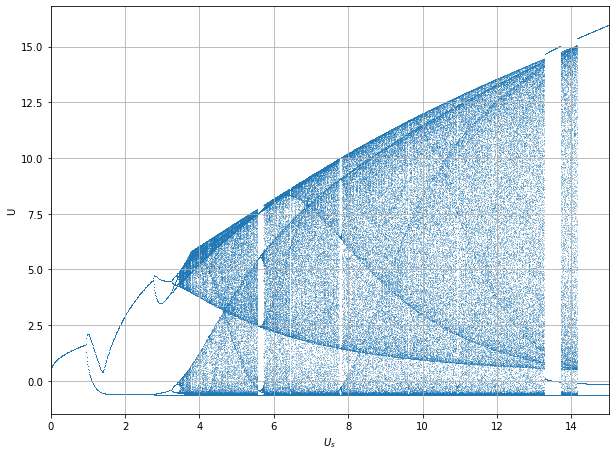

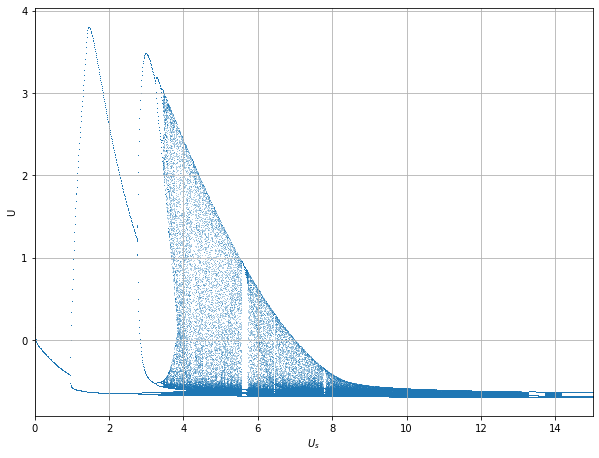

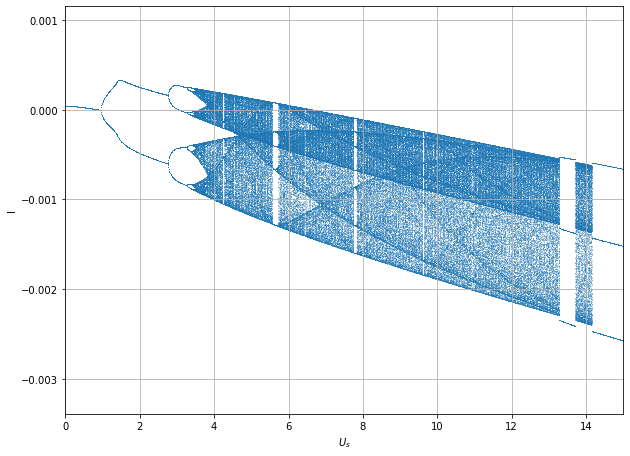

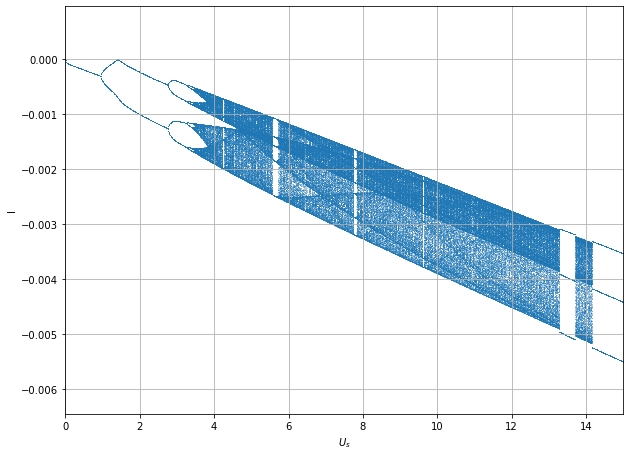

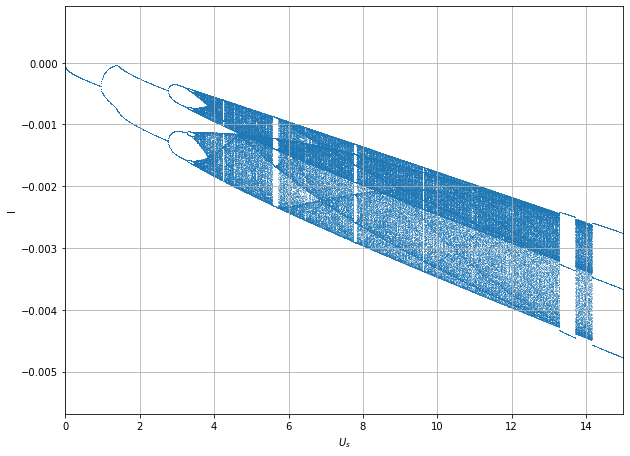

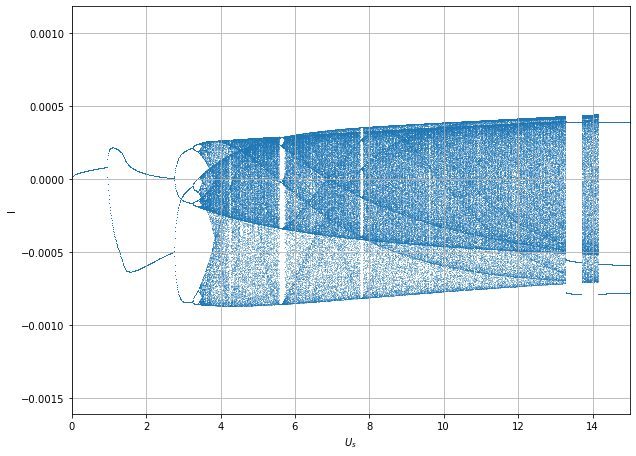

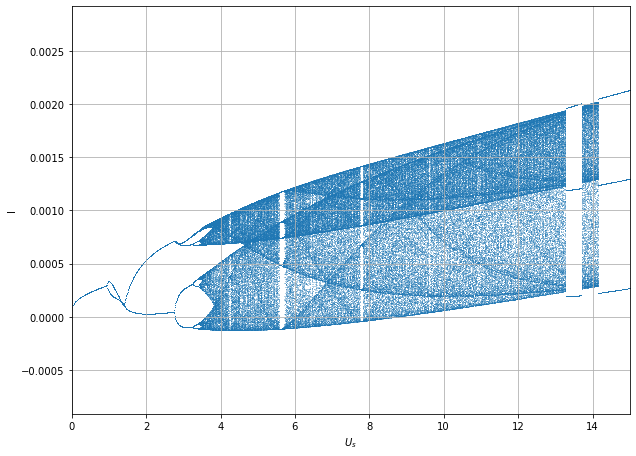

In [28]:
for var in [0, 1]:
    for phase in [0, 20, 40, 60, 80]:
        plt.scatter(Usplot, sol[:, nt - steps * samples - phase:nt - phase:steps, var].flat, marker=".", s=1, lw=0)
        plt.xlabel("$U_s$")
        plt.ylabel(["U", "I"][var])
        plt.xlim(Usmin, Usmax)
        plt.grid()
        plt.show()